# Example modeling process

### Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load training data and labels

In [2]:
x_train = get_training_observations()
y_train = get_training_labels()
le = load('../model_joblibs/xgb_labelEncoder.joblib')

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [52]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [54]:
len(x_train.columns)

16306

### Data manipulation
Validation splits, dimensionality reduction, etc

In [3]:
y_train['EMPO_3'] = le.transform(y_train['EMPO_3'])
y_train['EMPO_3'].head()

0     3
1    14
2     5
3     9
4    14
Name: EMPO_3, dtype: int64

In [4]:
# Split into train/validation if not CV
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train['EMPO_3'], test_size=0.2, random_state=0)

## Baseline

In [5]:
# function to plot the logloss
def eval_graphs(model):   
    results = model.evals_result()
    x_arr = np.arange(len(results['validation_0']['mlogloss']))+1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, results['validation_0']['mlogloss'], label='Train loss')
    if 'validation_1' in results:
        ax.plot(x_arr, results['validation_1']['mlogloss'], label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    plt.title('Model LogLoss Curve')
    
    if 'merror' in results['validation_0']:
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(x_arr, results['validation_0']['merror'], label='Train loss')
        if 'validation_1' in results:
              ax2.plot(x_arr, results['validation_1']['merror'], label='Validation loss')
        ax2.legend(fontsize=15)
        ax2.set_xlabel('Epoch', size=15)
        ax2.set_ylabel('MError', size=15)
        plt.title('Model MError Curve')
    plt.show()
    
    
def fit_model(model, x_tr=x_tr, y_tr=y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)], x_true=x_val, y_true=y_val):
    start = time.time()
    model.fit(x_tr,y_tr,
              eval_set=eval_set,
              early_stopping_rounds=10,
              verbose=0)
    stop = time.time()
    # predict validation data
    y_pred = model.predict(x_true)
    # print accuracy score 
    print("Training Set Accuracy Score on EMPO 3: ", accuracy_score(y_true, y_pred))
    # print model training time
    print(f"Baseline Model Training Time: {stop-start}s")
    return y_pred

In [12]:
baseline_model = xgb.XGBClassifier(objective='multi:softmax',
                                eval_metric=['merror','mlogloss'],
                                n_estimators = 500,
                                eta=0.03,
                                use_label_encoder=False)
# fit model and get predictions on validation set
baseline_pred = fit_model(baseline_model)
# plot loss curve
eval_graphs(baseline_model)

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


KeyboardInterrupt: 

In [62]:
baseline_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.03, eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

### Model Tuning

The baseline model has a training score that increases until 200 epochs. At later epochs, the log-loss and merror scores are fixed. From around 250 epochs, the variance is high but remains constant. The learning curve is ideal, with convergence and slight overfitting to demonstrate that the model is at optimal performance. However, we still still try fine-tuning hyperparameters to achieve the optimal parameters.

* increasing model complexity:
    * max_depth: integers from 8 to 20
    * min_child_weight: integers from 1 to 100
    * gamma: float between 0 and 4
* randomness:
    * lambda/reg_lambda: log scaling .001 to 1
    * alpha/reg_alpha: log scaling .001 to 10
    * learning_rate: log scaling .01 to 1
    * subsample: float between 0.2 and 1
    * colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1


In [11]:
# parameters that increase model complexity
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 6, 20, 1),
       'min_child_weight': hp.uniform('min_child_weight', 1, 20),
       'gamma': hp.uniform ('gamma', 0, 1),
       'reg_lambda': hp.uniform('reg_lambda', 1, 50),
       'reg_alpha': hp.uniform('reg_alpha', 0, 50),
       'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1)
        }

# define objective function
def objective(space):
    clf=xgb.XGBClassifier(objective='multi:softmax',
                          eta=0.03,
                          num_class=15,
                          eval_metric=['merror','mlogloss'],
                          n_estimators =300,
                          max_depth = int(space['max_depth']), 
                          min_child_weight=(space['min_child_weight']),
                          gamma = space['gamma'],
                          reg_lambda = space['reg_lambda'],
                          reg_alpha = space['reg_alpha'],
                          colsample_bytree = space['colsample_bytree'],
                          use_label_encoder=False)
    
    evaluation = [(x_tr, y_tr), (x_val, y_val)]
    # early stopping
    clf.fit(x_tr, y_tr,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=0)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                                          
0.916                                                                           
  1%|▏                | 1/100 [09:11<15:09:34, 551.25s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.836                                                                           
  2%|▎                | 2/100 [23:28<19:53:56, 730.99s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.844                                                                           
  3%|▌                | 3/100 [34:28<18:49:50, 698.87s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.868                                                                           
  4%|▋                | 4/100 [45:13<18:04:17, 677.68s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.868                                                                           
  5%|▊                | 5/100 [54:34<16:46:17, 635.55s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
  6%|▉              | 6/100 [1:04:57<16:29:07, 631.36s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.88                                                                            
  7%|█              | 7/100 [1:22:12<19:43:00, 763.23s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
  8%|█▏             | 8/100 [1:35:08<19:36:26, 767.24s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.86                                                                            
  9%|█▎             | 9/100 [1:48:46<19:47:54, 783.24s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.864                                                                           
 10%|█▍            | 10/100 [2:05:08<21:06:44, 844.50s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.836                                                                           
 11%|█▌            | 11/100 [2:13:59<18:30:14, 748.48s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.872                                                                           
 12%|█▋            | 12/100 [2:27:07<18:35:30, 760.57s/trial, best loss: -0.916]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 13%|█▊            | 13/100 [2:53:41<24:28:39, 1012.87s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.864                                                                           
 14%|██             | 14/100 [3:05:39<22:04:27, 924.04s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.864                                                                           
 15%|██▎            | 15/100 [3:12:55<18:20:24, 776.76s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
 16%|██▍            | 16/100 [3:26:13<18:16:32, 783.24s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.868                                                                           
 17%|██▌            | 17/100 [3:35:36<16:32:00, 717.12s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.9                                                                             
 18%|██▋            | 18/100 [3:48:59<16:55:18, 742.91s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.904                                                                           
 19%|██▊            | 19/100 [4:07:59<19:23:44, 862.02s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.896                                                                           
 20%|███            | 20/100 [4:18:40<17:41:05, 795.81s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 21%|███▏           | 21/100 [4:27:12<15:35:39, 710.63s/trial, best loss: -0.92]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 22%|██▊          | 22/100 [5:01:31<24:09:53, 1115.30s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 23%|██▉          | 23/100 [5:31:34<28:15:59, 1321.55s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 24%|███          | 24/100 [5:58:41<29:50:09, 1413.28s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 25%|███▎         | 25/100 [6:21:00<28:58:39, 1390.93s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 26%|███▍         | 26/100 [6:45:07<28:56:18, 1407.82s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 27%|███▌         | 27/100 [7:06:45<27:52:32, 1374.70s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 28%|███▋         | 28/100 [7:23:58<25:26:51, 1272.38s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 29%|███▊         | 29/100 [7:40:14<23:20:28, 1183.50s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 30%|███▉         | 30/100 [8:03:21<24:11:45, 1244.36s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 31%|████         | 31/100 [8:20:04<22:27:47, 1171.99s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 32%|████▏        | 32/100 [8:37:22<21:22:48, 1131.88s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.86                                                                            
 33%|████▎        | 33/100 [8:52:50<19:55:33, 1070.64s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.788                                                                           
 34%|████▊         | 34/100 [9:06:03<18:06:10, 987.44s/trial, best loss: -0.924]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 35%|████▌        | 35/100 [9:28:36<19:48:33, 1097.12s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 36%|█████         | 36/100 [9:39:06<17:00:32, 956.75s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 37%|█████▏        | 37/100 [9:56:57<17:20:38, 991.09s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 38%|████▉        | 38/100 [10:09:42<15:54:12, 923.42s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 39%|█████        | 39/100 [10:20:42<14:18:18, 844.24s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.8                                                                             
 40%|█████▏       | 40/100 [10:29:51<12:35:49, 755.83s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 41%|█████▎       | 41/100 [10:36:10<10:31:52, 642.59s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 42%|█████▍       | 42/100 [10:49:11<11:01:29, 684.31s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 43%|█████▌       | 43/100 [11:03:37<11:41:41, 738.63s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.832                                                                           
 44%|█████▋       | 44/100 [11:15:35<11:23:42, 732.54s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.892                                                                           
 45%|█████▊       | 45/100 [11:28:27<11:22:20, 744.36s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.864                                                                           
 46%|█████▉       | 46/100 [11:40:24<11:02:32, 736.16s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.86                                                                            
 47%|██████▌       | 47/100 [11:46:19<9:09:15, 621.80s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 48%|██████▋       | 48/100 [11:58:44<9:31:01, 658.87s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 49%|██████▊       | 49/100 [12:08:16<8:57:40, 632.56s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 50%|███████       | 50/100 [12:15:15<7:53:51, 568.62s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.884                                                                           
 51%|███████▏      | 51/100 [12:29:54<9:00:22, 661.68s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.896                                                                           
 52%|███████▎      | 52/100 [12:40:10<8:38:22, 647.97s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 53%|██████▉      | 53/100 [13:03:17<11:21:13, 869.65s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.824                                                                           
 54%|███████▌      | 54/100 [13:08:53<9:04:01, 709.59s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.892                                                                           
 55%|███████▋      | 55/100 [13:14:48<7:32:27, 603.27s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 56%|███████▊      | 56/100 [13:27:29<7:57:06, 650.61s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 57%|███████▉      | 57/100 [13:42:24<8:38:50, 723.96s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 58%|████████      | 58/100 [13:56:24<8:51:03, 758.65s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 59%|████████▎     | 59/100 [14:07:46<8:22:49, 735.85s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 60%|████████▍     | 60/100 [14:18:55<7:57:04, 715.60s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 61%|████████▌     | 61/100 [14:25:21<6:40:50, 616.69s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.872                                                                           
 62%|████████▋     | 62/100 [14:39:46<7:17:45, 691.21s/trial, best loss: -0.928]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 63%|████████▊     | 63/100 [14:51:14<7:05:42, 690.33s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 64%|████████▉     | 64/100 [15:02:18<6:49:23, 682.33s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.86                                                                            
 65%|█████████     | 65/100 [15:12:52<6:29:39, 667.99s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 66%|█████████▏    | 66/100 [15:20:36<5:43:49, 606.75s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 67%|█████████▍    | 67/100 [15:30:26<5:30:53, 601.61s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 68%|█████████▌    | 68/100 [15:38:45<5:04:32, 571.03s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 69%|█████████▋    | 69/100 [15:51:05<5:21:11, 621.68s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 70%|█████████▊    | 70/100 [16:02:10<5:17:22, 634.76s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 71%|█████████▉    | 71/100 [16:27:08<7:11:58, 893.73s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 72%|██████████    | 72/100 [16:38:58<6:31:14, 838.37s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 73%|██████████▏   | 73/100 [16:49:19<5:47:58, 773.29s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 74%|██████████▎   | 74/100 [16:59:14<5:11:54, 719.79s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 75%|██████████▌   | 75/100 [17:13:10<5:14:25, 754.61s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 76%|██████████▋   | 76/100 [17:27:24<5:13:47, 784.47s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 77%|██████████▊   | 77/100 [17:39:52<4:56:33, 773.61s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.796                                                                           
 78%|██████████▉   | 78/100 [17:47:11<4:06:48, 673.10s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 79%|███████████   | 79/100 [18:02:48<4:23:17, 752.26s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 80%|███████████▏  | 80/100 [18:15:38<4:12:33, 757.65s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 81%|███████████▎  | 81/100 [18:28:37<4:01:53, 763.89s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 82%|███████████▍  | 82/100 [18:40:42<3:45:41, 752.32s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 83%|███████████▌  | 83/100 [19:03:18<4:24:30, 933.58s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.888                                                                           
 84%|███████████▊  | 84/100 [19:10:59<3:31:07, 791.71s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 85%|███████████▉  | 85/100 [19:21:56<3:07:47, 751.16s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.932                                                                           
 86%|████████████  | 86/100 [19:36:36<3:04:17, 789.85s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 87%|████████████▏ | 87/100 [19:52:27<3:01:36, 838.17s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 88%|████████████▎ | 88/100 [20:09:16<2:57:56, 889.67s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 89%|████████████▍ | 89/100 [20:17:05<2:19:57, 763.38s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 90%|████████████▌ | 90/100 [20:38:04<2:32:00, 912.07s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.928                                                                           
 91%|████████████▋ | 91/100 [20:58:04<2:29:46, 998.46s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 92%|███████████▉ | 92/100 [21:15:04<2:13:57, 1004.71s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 93%|████████████ | 93/100 [21:34:49<2:03:32, 1058.98s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.912                                                                           
 94%|█████████████▏| 94/100 [21:42:53<1:28:39, 886.58s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
 95%|█████████████▎| 95/100 [21:54:51<1:09:38, 835.77s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.884                                                                           
 96%|███████████████▎| 96/100 [22:05:34<51:52, 778.01s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.872                                                                           
 97%|███████████████▌| 97/100 [22:15:54<36:32, 730.67s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.924                                                                           
 98%|███████████████▋| 98/100 [22:23:28<21:35, 647.69s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.916                                                                           
 99%|███████████████▊| 99/100 [22:36:17<11:23, 683.98s/trial, best loss: -0.932]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.92                                                                            
100%|███████████████| 100/100 [22:48:06<00:00, 820.87s/trial, best loss: -0.932]
The best hyperparameters are :  

{'colsample_bytree': 0.5531570152670522, 'gamma': 0.5935505534038723, 'max_depth': 17.0, 'min_child_weight': 6.61755010754711, 'reg_alpha': 4.070442822375122, 'reg_lambda': 6.330328526699605}


In [13]:
# Parameters for best and final model
best_model=xgb.XGBClassifier(objective='multi:softmax',
                             eta=0.03,
                             eval_metric=['merror','mlogloss'],
                             n_estimators =250,
                             )

Comparing the final model and the baseline model, the final model has a smaller difference between the train and validation loss. Thus, we will use the final model parameters.

Training Set Accuracy Score on EMPO 3:  0.924
Baseline Model Training Time: 1079.0975470542908s


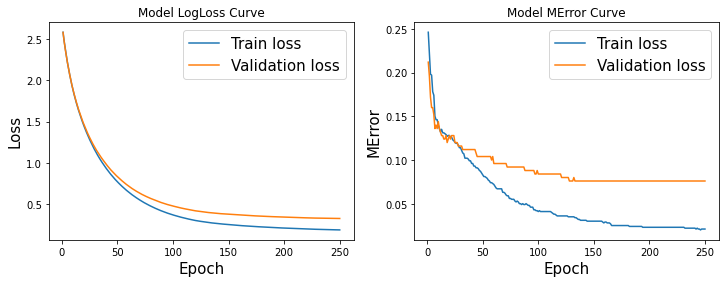

In [9]:
# fit model and get predictions on validation set
best_pred = fit_model(best_model)
# plot loss curve
eval_graphs(best_model)

### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

In [14]:
start = time.time() 
# fit to entire training dataset
best_model.fit(x_train, y_train['EMPO_3'],
                eval_set=[(x_train, y_train['EMPO_3'])],
                verbose=0)
stop = time.time()
print(best_model)
print(f"Model Training Time: {stop-start}s" )

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.03, eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, ...)
Model Training Time: 1716.4883699417114s


### Save fitted model

In [15]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
dump(best_model, '../model_joblibs/xgb_model.joblib')

['../model_joblibs/xgb_model.joblib']